## 0. 导入依赖 (Import Dependencies)

**[Ablation Study: Value + Condition]**
这是消融实验的进阶版。
在此配置中，我们将：
1. **保留 Value Embeddings** (丰度信息)
2. **保留 Condition Embeddings** (环境元数据)
3. **关闭 Cross-Attention** (不使用先验知识库)
4. 验证在没有 Cross-Attention 的情况下，仅靠环境上下文能带来多少提升。

In [1]:
import os
import torch
import warnings
from pickle import load
from argparse import Namespace
from configparser import ConfigParser
from importlib.resources import files

import pandas as pd
from torch.utils.data import Subset

from transformers import (
    Trainer,
    TrainingArguments,
)
from transformers.trainer_callback import EarlyStoppingCallback

from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForCausalLM
from MiCoGPT.utils_vCross.collator_vCross import MiCoGPTDataCollator
from MiCoGPT.utils.tools import split_train_val_by_project_stratified

warnings.filterwarnings("ignore")

## 1. 基本参数设置

In [2]:
args = Namespace(
    input="../data/vCross/ResMicroDB_90338_vCross.pkl",
    # [Ablation] 输出路径: Value + Condition
    output="../models/pretrain_vCross_value_condition",
    log="../logs/pretrain_vCross_value_condition",
    prior_npz=None
)
VAL_RATIO = 0.10

## 2. 载入语料库

In [3]:
print(f"Loading corpus from {args.input} ...")
all_corpus = load(open(args.input, "rb"))

if all_corpus.metadata is not None and "Split_Group" in all_corpus.metadata.columns:
    print("Subsetting corpus by Split_Group == 'A'...")
    corpus = all_corpus.subset_by_metadata(lambda df: df["Split_Group"] == "A")
else:
    print("Using full corpus (no Split_Group found or metadata missing).")
    corpus = all_corpus
    
tokenizer = all_corpus.tokenizer

Loading corpus from ../data/vCross/ResMicroDB_90338_vCross.pkl ...
Subsetting corpus by Split_Group == 'A'...
[subset_by_metadata] Selected 74557 samples out of 90338.


## 3. 提取环境元数据信息

这里我们需要正常提取 `condition_vocab_sizes`，因为我们要使用 Condition Embeddings。

In [4]:
if isinstance(corpus, Subset):
    base_corpus = corpus.dataset
else:
    base_corpus = corpus

condition_cols = list(base_corpus.meta_encoders.keys())
condition_vocab_sizes = [len(le.classes_) + 1 for le in base_corpus.meta_encoders.values()]

print("Condition Columns:", condition_cols)
print("Condition Vocab Sizes:", condition_vocab_sizes)

Condition Columns: ['Sample_Site']
Condition Vocab Sizes: [11]


## 4. 构建模型 (Value + Condition)

配置：
1. `num_bins=52` (保留 Value)
2. `condition_vocab_sizes=[...]` (保留 Condition)
3. `prior_matrix_path=None` & `add_cross_attention=False` (关闭 Cross-Attention)

In [5]:
cfg = ConfigParser()
cfg.read(files("MiCoGPT")/"resources/config.ini")

gpt2_config_dict = {
    "vocab_size":   tokenizer.vocab_size,
    "n_positions":  cfg.getint("GPT2", "n_positions"),
    "n_embd":       cfg.getint("GPT2", "n_embd"),
    "n_layer":      cfg.getint("GPT2", "n_layer"),
    "n_head":       cfg.getint("GPT2", "n_head"),
    "bos_token_id": tokenizer.bos_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "pad_token_id": tokenizer.pad_token_id,
}

config = MiCoGPTConfig(
    num_bins=52,                        # 保留 Value
    condition_vocab_sizes=condition_vocab_sizes, # 保留 Condition
    prior_matrix_path=None,             # 不用 Prior
    add_cross_attention=False,          # 关闭 Cross-Attention
    **gpt2_config_dict
)

model = MiCoGPTForCausalLM(config)
print("Model Config:", config)
print("Model Architecture:", model)
print("\n[Check] Cross Attention is:", "ENABLED" if config.add_cross_attention else "DISABLED")
print("[Check] Condition Embeddings:", len(model.condition_embeddings))

Model Config: MiCoGPTConfig {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "attn_pdrop": 0.1,
  "bos_token_id": 2,
  "condition_vocab_sizes": [
    11
  ],
  "embd_pdrop": 0.1,
  "eos_token_id": 3,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 256,
  "n_head": 8,
  "n_inner": null,
  "n_layer": 8,
  "n_positions": 512,
  "num_bins": 52,
  "pad_token_id": 0,
  "prior_matrix_path": null,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.33.3",
  "use_cache": true,
  "vocab_size": 1121
}

Model Architecture: MiCoGPTForCausalLM(
  (transformer): GPT2Model(
    (wte): Embedding(1121, 256)
    (wpe): Embedding(512, 256)
    (drop): Dropout(p=0.1, inplace=Fa

## 5. 初始化数据整理器 (正常模式)

使用标准的 `MiCoGPTDataCollator` 即可，它会正常返回 `input_ids`, `value_ids`, `condition_ids`。

In [6]:
collator = MiCoGPTDataCollator(
    tokenizer=tokenizer,
    max_length=config.n_positions
)

In [7]:
if isinstance(corpus, Subset):
    metadata = corpus.dataset.metadata
else:
    metadata = corpus.metadata

if metadata is not None and "Project_ID" in metadata.columns:
    print("Using stratified split by Project_ID...")
    train_dataset, val_dataset = split_train_val_by_project_stratified(
        corpus,
        val_ratio=VAL_RATIO,
        project_col="Project_ID"
    )
else:
    train_dataset, val_dataset = torch.utils.data.random_split(
        corpus, 
        [len(corpus)-int(len(corpus)*VAL_RATIO), int(len(corpus)*VAL_RATIO)], 
        generator=torch.Generator().manual_seed(42)
    )

Using stratified split by Project_ID...
[split] total_samples=74557, target_val~7456
[split] eligible_projects=304, eligible_samples=74367
[split] ineligible_projects=16, ineligible_samples=190
[split] actual_val=7456 (target~7456), train=67101


In [8]:
training_args = TrainingArguments(
    output_dir=f"{args.output}/checkpoints",
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    learning_rate=1e-3,
    weight_decay=0.01,
    logging_dir=args.log,
    logging_steps=100,
    save_steps=500,
    eval_steps=500,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_num_workers=0,
    dataloader_pin_memory=True,
    fp16=torch.cuda.is_available(),
    no_cuda=not torch.cuda.is_available(),
    report_to=["tensorboard"],
)

In [ ]:
# --- [New] 手动测试 Step 0 的 Validation Loss ---
print("Evaluating initial model (Step 0) ...")

# 调用 evaluate() 会使用 Trainer 初始化时传入的 eval_dataset 进行评估
init_eval_metrics = trainer.evaluate()

print("Initial Eval Metrics:", init_eval_metrics)

In [9]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
)
trainer.train()

Step,Training Loss,Validation Loss
500,5.062900,4.799671
1000,4.865700,4.663831
1500,4.815900,4.565474
2000,4.735000,4.483084
2500,4.677300,4.427817
3000,4.649900,4.378129
3500,4.572200,4.331350
4000,4.515800,4.292402
4500,4.506200,4.256044
5000,4.471600,4.224358


TrainOutput(global_step=42500, training_loss=4.1403744427849265, metrics={'train_runtime': 4992.8832, 'train_samples_per_second': 671.966, 'train_steps_per_second': 21.0, 'total_flos': 3.521008999858176e+16, 'train_loss': 4.1403744427849265, 'epoch': 20.27})

In [ ]:
import json
import matplotlib.pyplot as plt

trainer.save_model(args.output)
tokenizer.save_pretrained(args.output)

log_history = trainer.state.log_history
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.figure(figsize=(10, 6))
if train_steps: plt.plot(train_steps, train_loss, label="Training Loss", alpha=0.7)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o", linestyle="--")
plt.title("Ablation: Value + Condition (No Cross-Attn)")
plt.legend()
plt.savefig(f"{args.output}/loss_curve.png")
plt.show()

✅ Hotfix applied: 'save_vocabulary' method has been injected into the tokenizer.
Model and Tokenizer saved to ../models/pretrain_vCross_value_condition


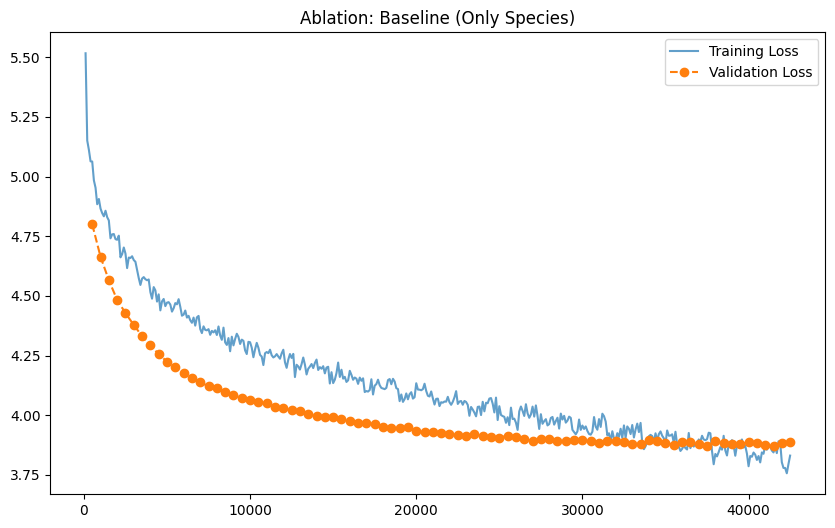

In [10]:
import os
import json
import types
import matplotlib.pyplot as plt

# --- 1. 临时补丁 (Hotfix) ---
# 在内存中定义缺失的 save_vocabulary 方法
def save_vocabulary_patch(self, save_directory: str, filename_prefix: str = None):
    if not os.path.isdir(save_directory):
        return
    
    vocab_file = os.path.join(
        save_directory, (filename_prefix + "-" if filename_prefix else "") + "vocab.json"
    )
    
    with open(vocab_file, "w", encoding="utf-8") as f:
        json.dump(self.vocab, f, ensure_ascii=False)
        
    return (vocab_file,)

# 将方法动态绑定到当前内存中的 tokenizer 类上
# 这样不需要重启内核，当前的 tokenizer 实例就能立刻拥有这个方法
tokenizer.__class__.save_vocabulary = save_vocabulary_patch
print("✅ Hotfix applied: 'save_vocabulary' method has been injected into the tokenizer.")

# --- 2. 执行保存与分析逻辑 ---

# 保存模型
trainer.save_model(args.output)
# 现在这一步应该能成功了，因为它会调用我们刚刚注入的 patch 方法
tokenizer.save_pretrained(args.output)
print(f"Model and Tokenizer saved to {args.output}")

# 导出日志
log_history = trainer.state.log_history
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.figure(figsize=(10, 6))
if train_steps: plt.plot(train_steps, train_loss, label="Training Loss", alpha=0.7)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o", linestyle="--")
plt.title("Ablation: Baseline (Only Species)")
plt.legend()
plt.savefig(f"{args.output}/loss_curve.png")
plt.show()